In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional


sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))


from src.agents.base_agent import BaseAgent
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

In [2]:
import torch
import torch.nn as nn
from sklearn.utils import gen_batches
from sklearn.base import BaseEstimator

class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super().__init__()
        self.m = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.m(x)

class ConvNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        super(ConvNet, self).__init__()
        # input shape: Bx2x32x32
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=2, padding=1)   # Bx64x16x16
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)   # Bx64x8x8
        self.pool2 = nn.AvgPool2d(kernel_size=8, stride=1, padding=0)  # Bx64x1x1
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


def normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val)


class SailingModel(nn.Module):
    def __init__(self):
        super(SailingModel, self).__init__()
        self.fc = FCNet(17, 32, 9)
        self.goal = nn.Parameter(torch.tensor([16.0, 31.0]), requires_grad=False)
        # self.fc = FCNet(7, 32, 9)
        self.conv = ConvNet()
    
    def forward(self, x):
        observations, windfield = x[:, :6], x[:, 6:]
        normalized_state = torch.cat([
            normalize(observations[:, 0:1], 0, 31),
            normalize(observations[:, 1:2], 0, 31),
            normalize(observations[:, 2:3], 0, 2),
            normalize(observations[:, 3:4], 0, 2),
            normalize(observations[:, 4:5], 0, 5),
            normalize(observations[:, 5:6], 0, 5),
        ], dim=1)

        # Add distance to the goal
        dist_to_goal = torch.norm(observations[:, [0, 1]] - self.goal.to(x.device), dim=1, keepdim=True) / 35
        observations = torch.cat((normalized_state, dist_to_goal), dim=1)

        windfield = windfield.view(-1, 2, 32, 32)
        windfield = self.conv(windfield)
        out = self.fc(torch.cat((observations, windfield), dim=1))
        # out = self.fc(observations)

        return out


class NN(BaseEstimator):
    """
    A sklearn-like class for the neural net
    """
    def __init__(self, n_iterations, lr, batch_size) -> None:
        """
        Initialize the sklearn class:
        - Record the input parameters using
        self.parameter = parameter
        - Initialize the neural network model and record it in self.model
        - Initialize the Adam optimizer and record it in self.optimizer
        """
        super().__init__()
        self.n_iterations = n_iterations
        self.lr = lr
        self.batch_size = batch_size

        self.model = SailingModel()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = "cpu"
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)


    def partial_fit(self, X, Y):
        Xs = X[:, :-1]
        Xa = X[:, -1]
        Xs = torch.from_numpy(Xs.copy()).to(torch.float32).to(self.device)
        Xa = torch.from_numpy(Xa.copy()).to(torch.int64).to(self.device)
        Y = torch.from_numpy(Y.copy()).to(torch.float32).to(self.device)

        loss = ((self.model(Xs)[torch.arange(len(Xs)), Xa] - Y) ** 2).sum() / len(Xs)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()


    def fit(self, X, Y):
        idx_samples = np.arange(len(X))
        for _ in range(self.n_iterations):
            np.random.shuffle(idx_samples)
            for batch_slice in gen_batches(len(X), self.batch_size):
                Xb, Yb = X[idx_samples[batch_slice]].copy(), Y[idx_samples[batch_slice]].copy()
                self.partial_fit(Xb, Yb)

    def predict(self, X):
        Xs = X[:, :-1]
        Xa = X[:, -1]
        with torch.no_grad():
            Xs = torch.from_numpy(Xs.copy()).to(torch.float32).to(self.device)
            Xa = torch.from_numpy(Xa.copy()).to(torch.int64).to(self.device)
            y = self.model(Xs)[torch.arange(len(Xs)), Xa]
        return y.cpu().numpy()

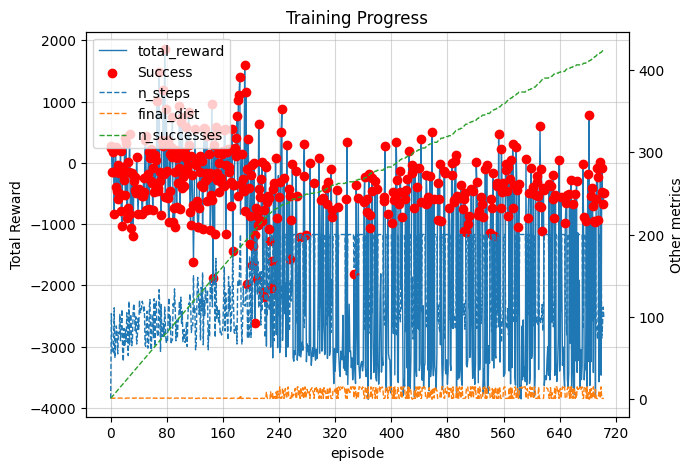

100%|██████████| 100000/100000 [1:04:21<00:00, 25.90it/s, success_rate=0.00788]


In [3]:
from src.agents.agent_dqn import DQN
from src.agents.moutet_maxime_submission01 import GreedyAgent


env = SailingEnv(**get_initial_windfield('training_1'))

capacity = 25000
batch_size = 32
eps = 0.05
gamma = 0.99
C = 8
model = NN(n_iterations=1000, lr=0.001, batch_size=batch_size)
n_iterations = 100000
pi_demo = GreedyAgent().act
pi = DQN(env, model, capacity, batch_size, C, eps, gamma, n_iterations, pi_demo)

In [4]:
class Agent(BaseAgent):
    def __init__(self, params: Optional[dict] = None):
        super().__init__()


    def act(self, observation: np.ndarray) -> int:
        """
        Given an observation, return an action.
        """
        # For this example, we will just return a random action
        a = pi(observation)
        return a
    
    def reset(self) -> None:
        """Reset the agent's internal state.
        
        This method is called at the beginning of each episode.
        Override this method if your agent maintains internal state.
        """
        pass
    
    def seed(self, seed: Optional[int] = None) -> None:
        """Set the random seed for this agent.
        
        Args:
            seed: The random seed to use. If None, a random seed will be used.
        """
        self.np_random = np.random.default_rng(seed) 

### Run on the static windfielf

Running the naive agent on the simple_static initial windfield:
Step 20: Position=[16  6], Reward=0.0


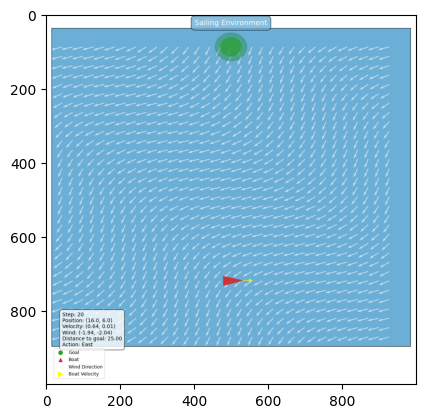

Step 40: Position=[12 13], Reward=0.0


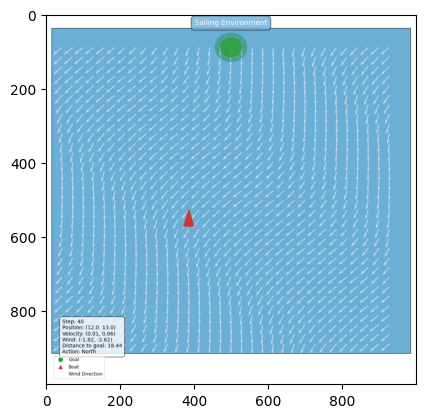

Step 60: Position=[ 6 21], Reward=0.0


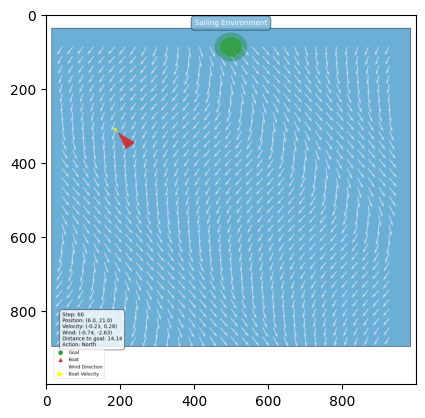

Step 80: Position=[ 5 24], Reward=0.0


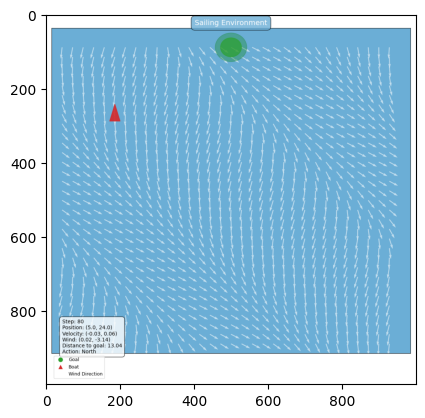

Step 100: Position=[12 26], Reward=0.0


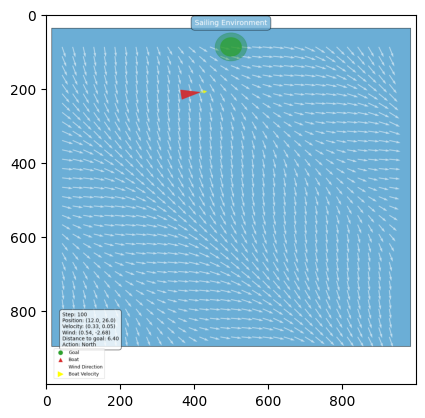


Episode finished after 110 steps with reward: 100.0
Final position: [15 30]
Goal reached: True


In [5]:
# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('training_1'))
agent = Agent()

# Run a single episode
observation, info = env.reset()
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 200:  # Limit to 100 steps
    action = agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 20 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")
        plt.imshow(env.render())
        plt.show()

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

In [ ]:
from src.evaluate_submission import evaluate_agent
from src.evaluation import visualize_trajectory
#############################################
### MODIFY THESE PARAMETERS AS NEEDED ######
#############################################

agent = Agent()
# Set to True to enable visualization
VISUALIZE = True

# Visualization parameters
VIZ_INITIAL_WINDFIELD_NAME = "training_1"  # Choose which initial windfield to visualize
VIZ_SEED = 42                   # Choose a single seed for visualization
MAX_HORIZON = 200 

#############################################
### DO NOT MODIFY BELOW THIS LINE ##########
#############################################

# Only run if visualization is enabled and agent is loaded
if VISUALIZE and 'agent' in locals():
    # Get the initial windfield with visualization parameters
    viz_initial_windfield = get_initial_windfield(VIZ_INITIAL_WINDFIELD_NAME)
    viz_initial_windfield.update({
        'env_params': {
            'wind_grid_density': 25,
            'wind_arrow_scale': 80,
            'render_mode': "rgb_array"
        }
    })
    
    print(f"Visualizing agent behavior on initial windfield: {VIZ_INITIAL_WINDFIELD_NAME}")
    print(f"Using seed: {VIZ_SEED}")
    
    # Run the evaluation with visualization enabled
    viz_results = evaluate_agent(
        agent=agent,
        initial_windfield=viz_initial_windfield,
        seeds=VIZ_SEED,
        max_horizon=MAX_HORIZON,
        verbose=False,
        render=True,
        full_trajectory=True,  # Enable full trajectory for visualization
        # close=True
    )
    
    # Visualize the trajectory with a slider
    visualize_trajectory(viz_results, None, with_slider=True)
else:
    if 'agent' in locals():
        print("Visualization is disabled. Set VISUALIZE = True to see agent behavior.")

Visualizing agent behavior on initial windfield: training_1
Using seed: 42


interactive(children=(IntSlider(value=0, description='Step:', max=199), Output()), _dom_classes=('widget-inter…

## Train Agent

In [9]:
# Create our Q-learning agent for full training
params = {}
agent = Agent(params=params)

# Set fixed seed for reproducibility
np.random.seed(42)
agent.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('training_1'))

# Training parameters
num_episodes = 10  # More episodes for better learning
max_steps = 1000

# Progress tracking
rewards_history = []
steps_history = []
success_history = []

# Training loop
print("Starting full training with 100 episodes...")
import time
start_time = time.time()

for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = agent.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = agent.discretize_state(next_observation)
        
        # Update Q-table
        agent.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    rewards_history.append(total_reward)
    steps_history.append(step+1)
    success_history.append(done)
    
    # Update exploration rate (decrease over time)
    agent.exploration_rate = max(0.05, agent.exploration_rate * 0.98)
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        success_rate = sum(success_history[-10:]) / 10 * 100
        print(f"Episode {episode+1}/100: Success rate (last 10): {success_rate:.1f}%")

training_time = time.time() - start_time

# Calculate overall success rate
success_rate = sum(success_history) / len(success_history) * 100

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(agent.q_table)} states")

Starting full training with 100 episodes...


AttributeError: 'Agent' object has no attribute 'discretize_state'

## Visualize

In [6]:
# Calculate rolling averages
window_size = 10
rolling_rewards = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
rolling_steps = np.convolve(steps_history, np.ones(window_size)/window_size, mode='valid')
rolling_success = np.convolve([1 if s else 0 for s in success_history], np.ones(window_size)/window_size, mode='valid') * 100

# Create the plots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot rewards
ax1.plot(rolling_rewards)
ax1.set_ylabel('Average Reward')
ax1.set_title('Training Progress (10-episode rolling average)')

# Plot steps
ax2.plot(rolling_steps)
ax2.set_ylabel('Average Steps')

# Plot success rate
#ax3.plot(rolling_success)
#ax3.set_ylabel('Success Rate (%)')
#ax3.set_xlabel('Episode')

plt.tight_layout()
plt.show()

NameError: name 'rewards_history' is not defined

## Test

In [9]:
agent = GreedyAgent()

# Create test environment
# test_env = SailingEnv(**get_initial_windfield('training_1'))
test_env = env

# Test parameters
num_test_episodes = 5
max_steps = 1000

print("Testing the trained agent on 5 new episodes...")
# Testing loop
for episode in range(num_test_episodes):
    # Reset environment
    observation, info = test_env.reset(seed=1000 + episode)  # Different seeds from training
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action using learned policy
        action = agent.act(observation)
        observation, reward, done, truncated, info = test_env.step(action)
        
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Test Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")

Testing the trained agent on 5 new episodes...
Test Episode 1: Steps=48, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 2: Steps=57, Reward=100.0, Position=[16 30], Goal reached=True
Test Episode 3: Steps=66, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 4: Steps=106, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 5: Steps=94, Reward=100.0, Position=[15 30], Goal reached=True
